In [1]:
import pandas as pan
import numpy as np
import matplotlib.pyplot as plotter
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 

In [2]:
matrix_data = pan.read_csv("wine_fraud.csv")

In [3]:
matrix_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Legit,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Legit,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Legit,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red


In [4]:
cat_data = matrix_data["type"]
non_cat_data = matrix_data.drop("type", axis = 1)

In [5]:
dummies = pan.get_dummies(cat_data, drop_first = True)
final_matrix_data = non_cat_data.merge(how = "inner", right = dummies, left_index = True, right_index = True)

In [6]:
#unique vars in the target column
final_matrix_data["quality"].value_counts()

quality
Legit    6251
Fraud     246
Name: count, dtype: int64

<Axes: xlabel='quality', ylabel='count'>

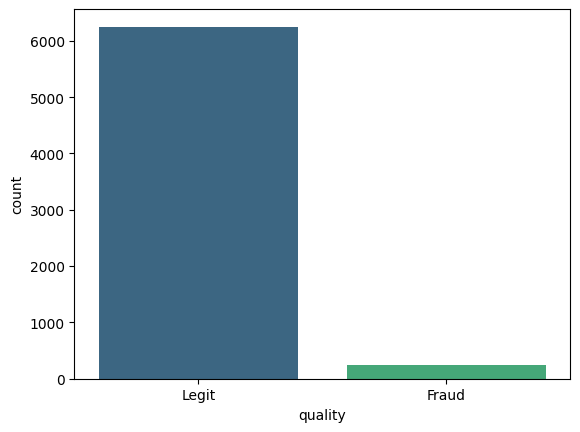

In [7]:
sns.countplot(x = final_matrix_data["quality"], palette = "viridis")
#highly unbalanced data

<Axes: xlabel='type', ylabel='count'>

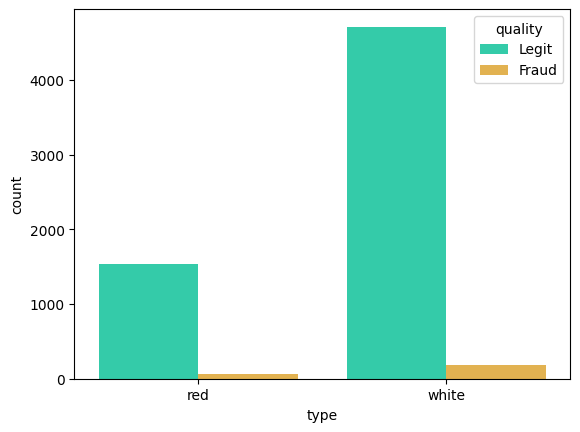

In [8]:
sns.countplot(x = matrix_data["type"], hue = matrix_data["quality"], palette = "turbo")

In [9]:
#what percent of red and white wines are frauds
#white
len(matrix_data[(matrix_data["type"] == "white" )&(matrix_data["quality"] == "Fraud")])/len(matrix_data[matrix_data["type"] == "white"]) * 100
len(matrix_data[(matrix_data["type"] == "red" )&(matrix_data["quality"] == "Fraud")])/len(matrix_data[matrix_data["type"] == "red"]) * 100

3.9399624765478425

In [10]:
test_matrix_data = pan.DataFrame(matrix_data)
test_matrix_data["quality"] = test_matrix_data["quality"].map({"Legit": 0, "Fraud": 1})
test_matrix_data.corr(numeric_only = True)["quality"].sort_values()

free sulfur dioxide    -0.085204
citric acid            -0.061789
alcohol                -0.051141
residual sugar         -0.048756
total sulfur dioxide   -0.035252
sulphates              -0.034046
density                 0.016351
pH                      0.020107
fixed acidity           0.021794
chlorides               0.034499
volatile acidity        0.151228
quality                 1.000000
Name: quality, dtype: float64

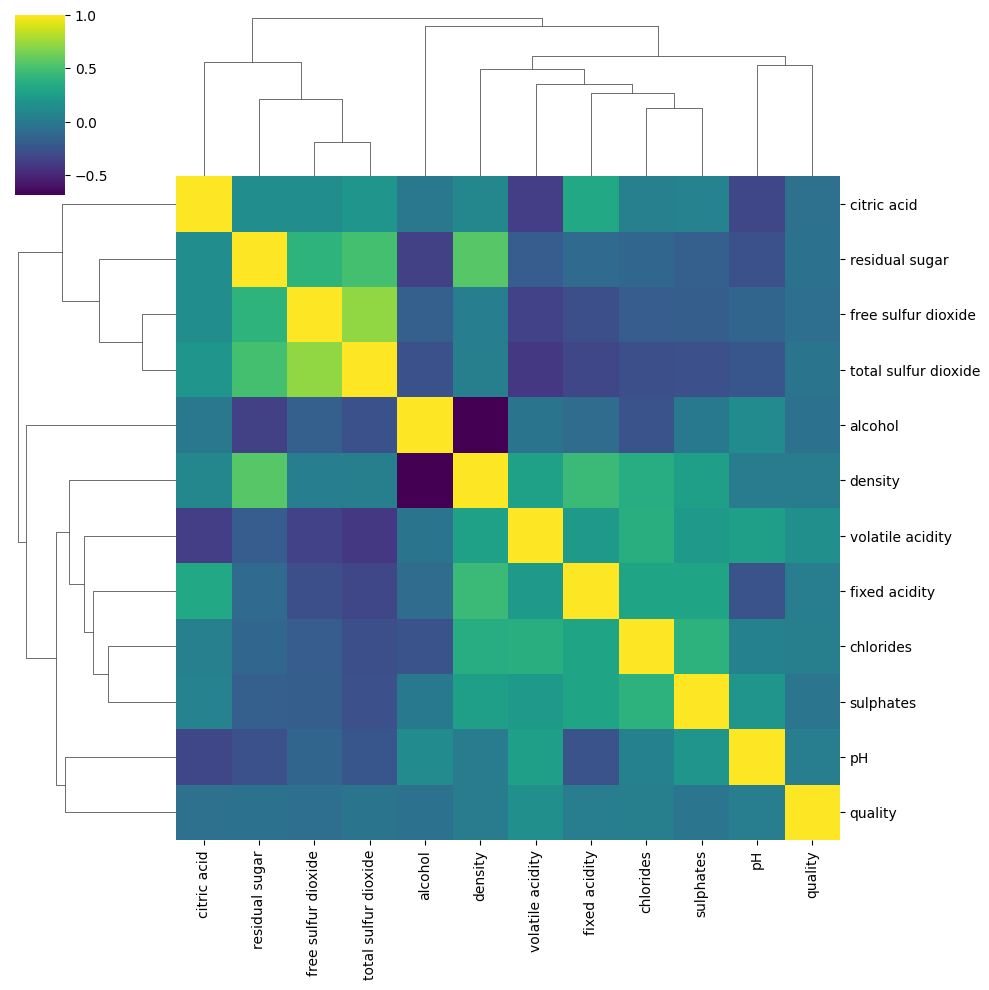

In [31]:
sns.clustermap(test_matrix_data.corr(numeric_only = True), cmap = "viridis")

In [34]:
features = final_matrix_data.drop("quality", axis = 1)
label = final_matrix_data["quality"]
feature_train, feature_test, label_train, label_test = train_test_split(features, label, random_state = 42, test_size = 0.1)
scaler = StandardScaler()
feature_train = scaler.fit_transform(feature_train)
feature_test = scaler.transform(feature_test)
sub_gridder = SVC(class_weight = "balanced")
params = {"kernel": ["rbf", "linear"], "C": [0.05, 0.1, 1, 10, 100], "gamma": ["scale", "auto"]}
gridder = GridSearchCV(sub_gridder, params, verbose = 1, cv = 7)

In [35]:
gridder.fit(feature_train, label_train)

Fitting 7 folds for each of 20 candidates, totalling 140 fits


GridSearchCV(cv=7, estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.05, 0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear']},
             verbose=1)

In [36]:
predictions = gridder.predict(feature_test)

In [38]:
gridder.best_params_

{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

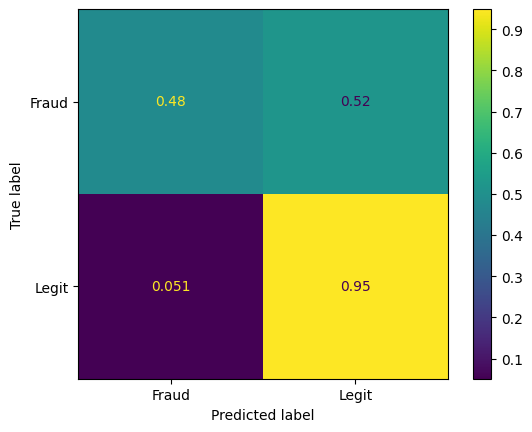

In [40]:
ConfusionMatrixDisplay.from_predictions(label_test, predictions, normalize = "true")

In [41]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

       Fraud       0.27      0.48      0.35        25
       Legit       0.98      0.95      0.96       625

    accuracy                           0.93       650
   macro avg       0.63      0.71      0.66       650
weighted avg       0.95      0.93      0.94       650

